In [ ]:
import numpy as np
import os
import subprocess
import sys
import json
import matplotlib.pyplot as plt
import torch
import json
import os

In [2]:
colab = True
token = ""
repo_owner = "esemsc-dda24"
repo_name = "PTL-PINNS"

## Using colab?

In [3]:
if colab:

    def clone_repo(repo_owner: str, repo_name: str, token: str = None):
        """
        Clone a GitHub repo using a token. Token can be passed or taken from GITHUB_TOKEN env var.
        """
        token = token or os.getenv("GITHUB_TOKEN")
        if not token:
            raise ValueError("GitHub token not provided or found in environment variables.")

        url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"
        target_dir = repo_name

        if not os.path.exists(target_dir):
            try:
                subprocess.run(["git", "clone", url], check=True)
                print(f"Successfully cloned '{repo_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error cloning repo: {e}")
        else:
            print(f"Directory '{target_dir}' already exists; skipping git clone.")

    clone_repo(repo_owner, repo_name, token)
    sys.path
    sys.path.append(f"/content/{repo_name}/")
    !pip install neurodiffeq > /dev/null 2>&1
    %cd /{repo_name}
    !ls
    !pip install -e .

ValueError: GitHub token not provided or found in environment variables.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from ptlpinns.models import model, train_PDE
from ptlpinns.odes import forcing, equations, numerical

## Training equations

In [ ]:
L, T = 2, 5
x_span = (0, L)
t_span = (0, T)
Nx, Nt = 150, 150

In [ ]:
def forcing_zeros(input):
    x = input[:, 0].unsqueeze(1)
    return torch.zeros_like(x)

def ic_sin(input):
    x = input[:, 0].unsqueeze(1)
    return torch.sin(torch.pi*x / L)

def ic_zero(input):
    x = input[:, 0].unsqueeze(1)
    return torch.zeros_like(x)

def first_order(D):

    def helper_first_order(input):
        x = input[:, 0].unsqueeze(1)
        t = input[:, 1].unsqueeze(1)

        u_0 = torch.exp(torch.tensor(- D * t * (torch.pi / L) ** 2)) * torch.sin(torch.pi * x / L)
        return u_0 * (1 - u_0)

    return helper_first_order

def general_forcing(n, alpha, D):

    def helper_general_forcing(input):
        x = input[:, 0].unsqueeze(1)
        t = input[:, 1].unsqueeze(1)

        lambda_param = D * (n * torch.pi / L) ** 2

        return torch.exp(- alpha * lambda_param * t) * torch.sin(n * torch.pi * x / L)

    return helper_general_forcing

In [ ]:
k = 9
D_list = torch.tensor([0.1, 0.05, 0.01, 0.1, 0.05, 0.01, 0.1, 0.05, 0.01])

boundary_values = [[0,0]] * k

Forcing_functions = [forcing_zeros, forcing_zeros, forcing_zeros,
                     first_order(D_list[3]), first_order(D_list[4]), first_order(D_list[5]),
                     general_forcing(1, 1, D_list[6]), general_forcing(2, 2, D_list[7]), general_forcing(1, 2, D_list[8])]

initial_conditions = [ic_sin, ic_sin, ic_sin, ic_zero, ic_zero, ic_zero, ic_zero, ic_zero, ic_zero]

In [ ]:
PTL_PINN = model.Multihead_model_PDE(k=k, bias=True)

In [ ]:
learning_rate = 1e-3
num_iter= 25000
interior_grid = (15, 15)
Nic = Nx
Nbc = Nt
method='equally-spaced-noisy'
pde_weight = 1; bc_weight = 5; ic_weight=5
every= 400
optimizer=torch.optim.Adam(PTL_PINN.parameters(), lr=learning_rate)
step_size = 1000
gamma = 0.95
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PTL_PINN.to(dev)

loss_trace, pde_trace, ic_trace, bc_trace, result_trace = train_PDE.train(model=PTL_PINN, optimizer=optimizer, num_iter=num_iter, Forcing_functions=Forcing_functions,
                                                                        boundary_values=boundary_values, initial_value=initial_conditions, coeff=D_list,
                                                                        interior_grid=interior_grid, x_span=x_span, t_span=t_span,
                                                                        Nic=Nic, Nbc=Nbc, every=100, pde_weight=pde_weight, bc_weight=bc_weight,
                                                                        ic_weight=ic_weight, scheduler=scheduler, method=method, equation = "KPP-Fisher")

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


[   100] Iter | Total: 9.2159e-02 | PDE: 8.0474e-02 (w=1) | IC: 4.9214e-04 (w=10) | BC: 6.7630e-04 (w=10)
[   200] Iter | Total: 7.8750e-02 | PDE: 7.3467e-02 (w=1) | IC: 2.2821e-04 (w=10) | BC: 3.0012e-04 (w=10)
[   300] Iter | Total: 7.9230e-02 | PDE: 7.0624e-02 (w=1) | IC: 2.7021e-04 (w=10) | BC: 5.9047e-04 (w=10)
[   400] Iter | Total: 7.0921e-02 | PDE: 6.1644e-02 (w=1) | IC: 1.7596e-04 (w=10) | BC: 7.5176e-04 (w=10)
[   500] Iter | Total: 6.0501e-02 | PDE: 5.7152e-02 (w=1) | IC: 1.0669e-04 (w=10) | BC: 2.2822e-04 (w=10)
[   600] Iter | Total: 4.5527e-02 | PDE: 4.2837e-02 (w=1) | IC: 7.4000e-05 (w=10) | BC: 1.9501e-04 (w=10)
[   700] Iter | Total: 3.8965e-02 | PDE: 3.6055e-02 (w=1) | IC: 1.0775e-04 (w=10) | BC: 1.8321e-04 (w=10)
[   800] Iter | Total: 3.7164e-02 | PDE: 3.3944e-02 (w=1) | IC: 1.1484e-04 (w=10) | BC: 2.0715e-04 (w=10)
[   900] Iter | Total: 2.8360e-02 | PDE: 2.5695e-02 (w=1) | IC: 1.0071e-04 (w=10) | BC: 1.6583e-04 (w=10)
[  1000] Iter | Total: 2.8762e-02 | PDE: 2.496

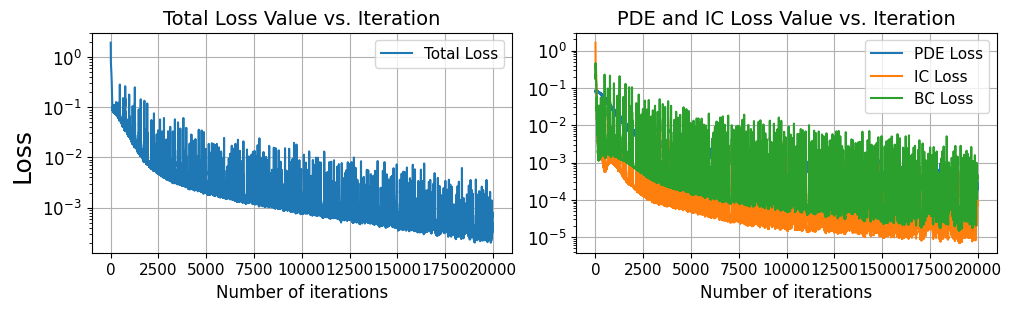

In [ ]:
train_PDE.plot_loss(loss_trace, pde_trace, bc_trace, ic_trace)

In [ ]:
# compute the NN solutions
PTL_PINN.eval()
x, tau, grid = train_PDE.generate_interior_tensor(IG=(Nx, Nt), x_span=(0, L), t_span=(0, T), require_grad=False)
NN_solution, _ = PTL_PINN(grid.to(dev))

NN_solution = NN_solution.mT.reshape((k,Nx, Nt)).detach().cpu().numpy()

In [ ]:
NN_solution.shape

(9, 120, 120)

In [ ]:
x = np.linspace(x_span[0], x_span[1], Nx)
t = np.linspace(t_span[0], t_span[1], Nt)
mesh_x, mesh_t = np.meshgrid(x, t)

In [ ]:
D_list = [0.1, 0.05, 0.01, 0.1, 0.05, 0.01, 0.1, 0.05, 0.01]

numerical_solutions = [numerical.kpp_fisher_u0(mesh_x, mesh_t, L, D_list[0]),
                       numerical.kpp_fisher_u0(mesh_x, mesh_t, L, D_list[1]),
                       numerical.kpp_fisher_u0(mesh_x, mesh_t, L, D_list[2])]

def zero_initial(x):
    return np.zeros_like(x)

u_0 = [zero_initial for _ in range(3)]
forcing = [lambda x, t: numerical.kpp_fisher_u0(x, t, L, D_list[i]) * (1 - numerical.kpp_fisher_u0(x, t, L, D_list[i])) for i in range(3, 6)]
bcs = [[lambda t: 0, lambda t: 0] for _ in range(3)]
polynomial = [lambda u: -u + u**2 for _ in range(3)]

for i in range(3, 6):
    result_kpp = numerical.solution_KPP([0], D_list[i], polynomial, x_span, t_span, Nx, Nt, u_0, forcing, bcs).squeeze().swapaxes(0, 1)
    numerical_solutions.append(result_kpp)

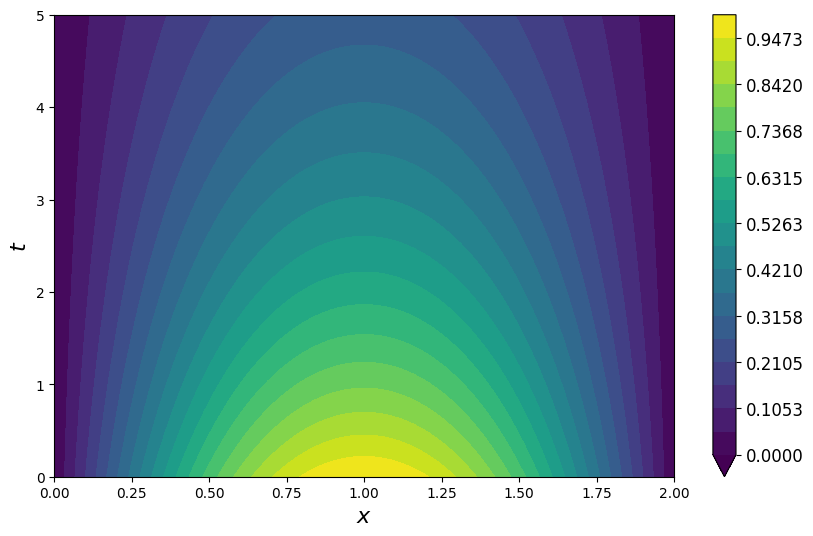

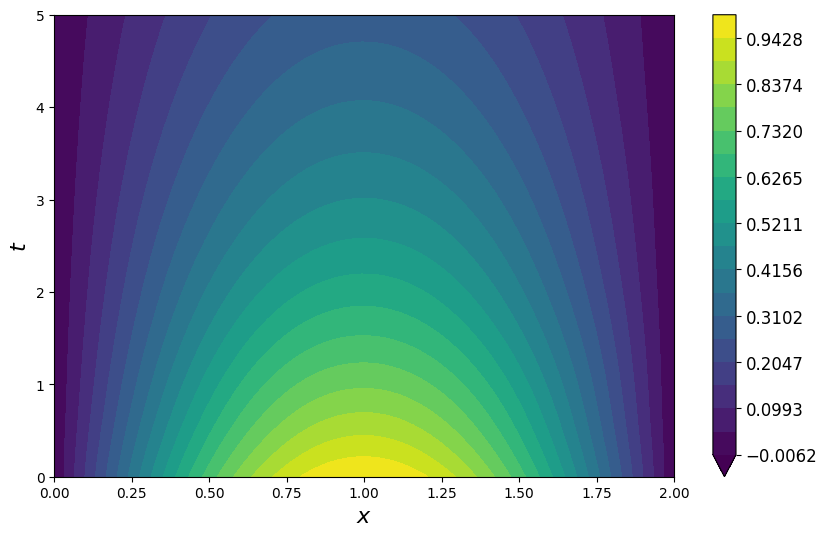

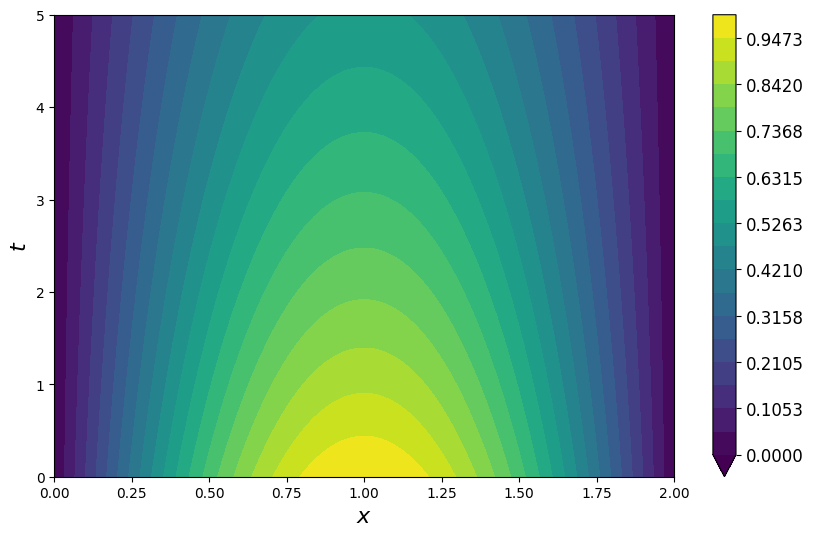

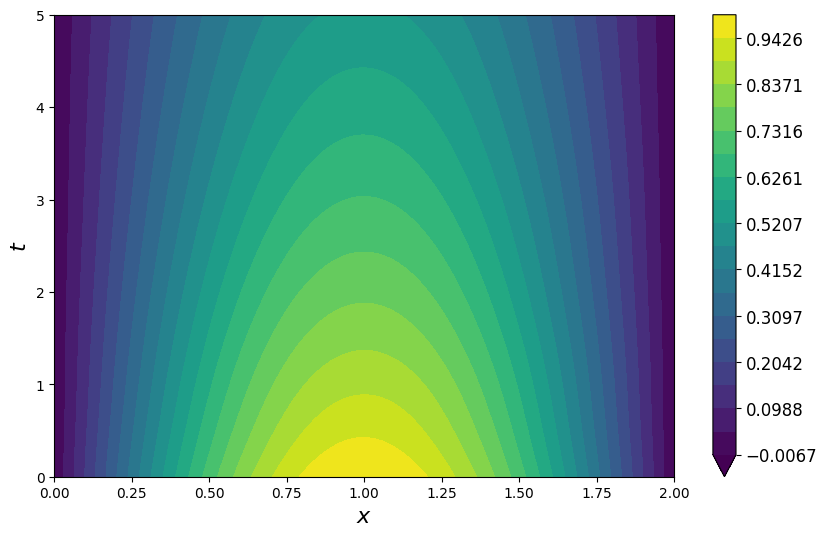

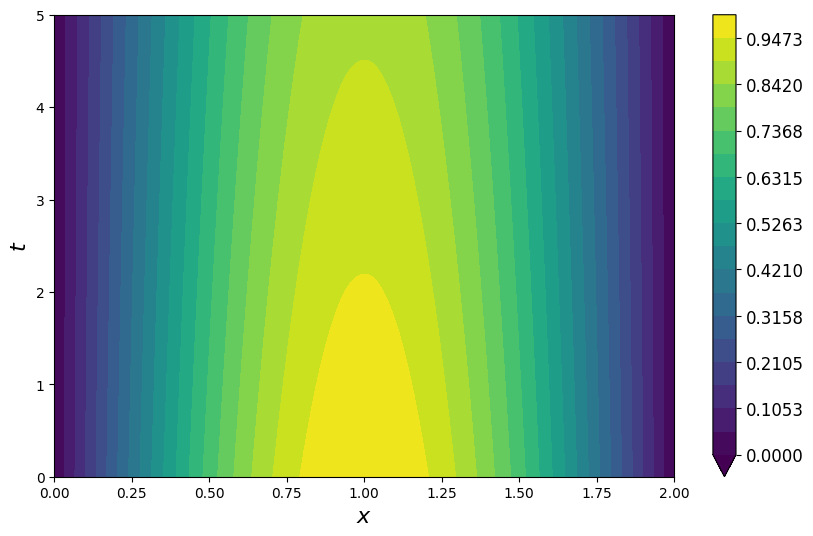

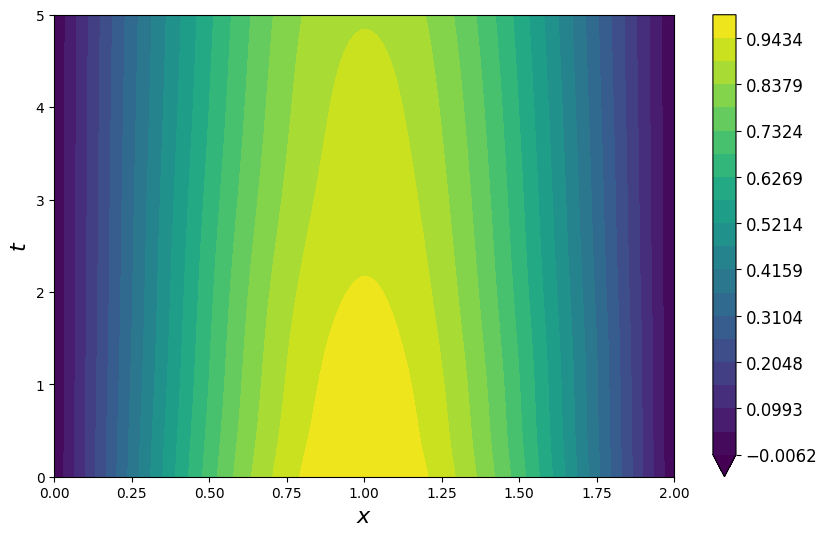

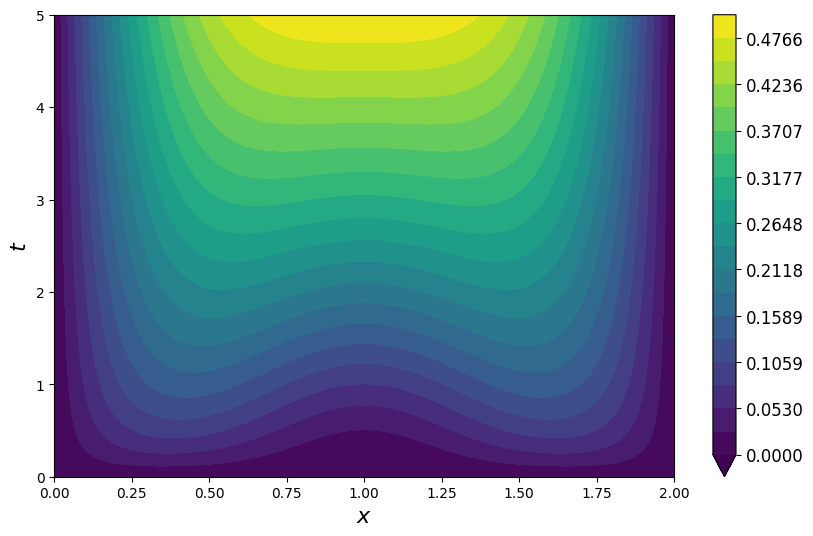

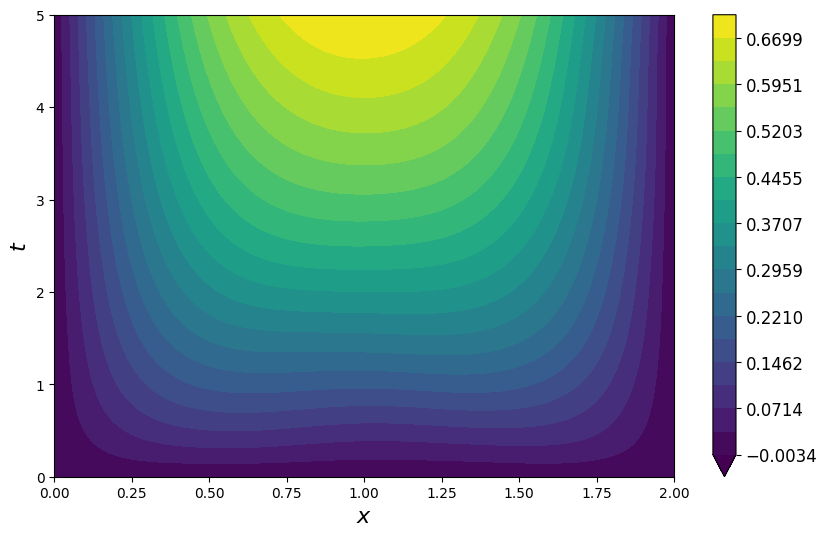

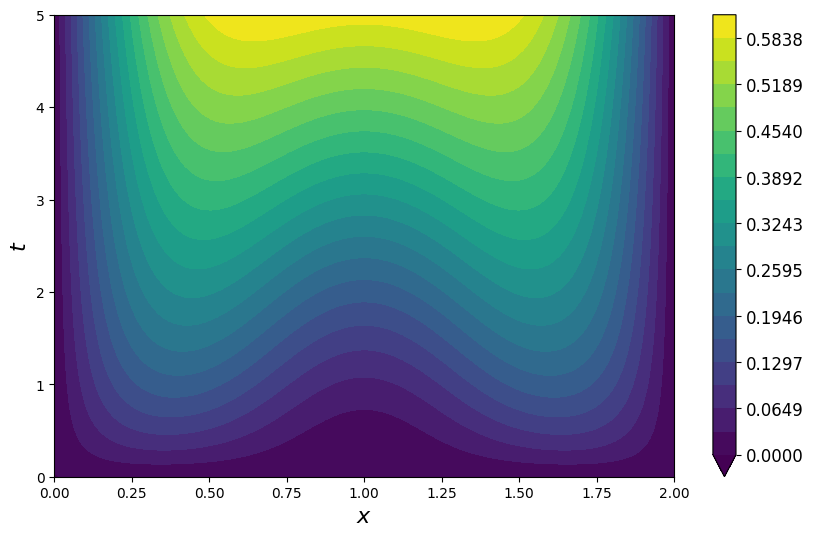

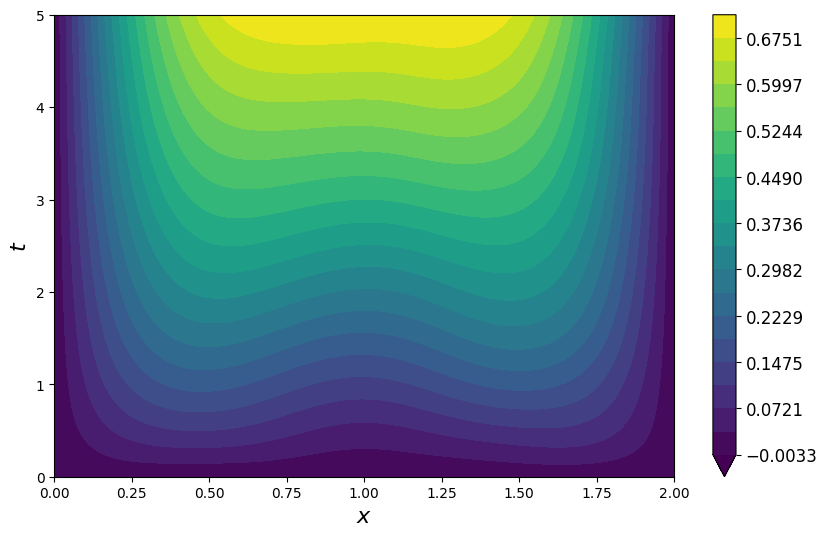

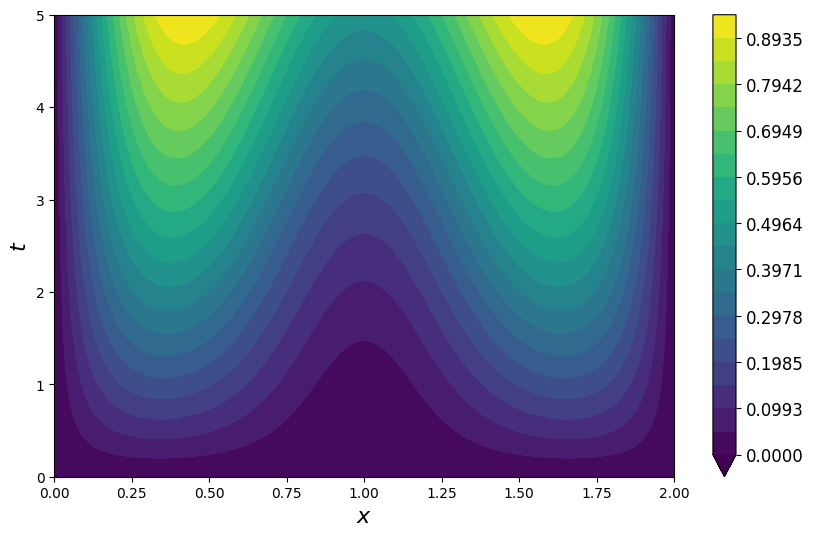

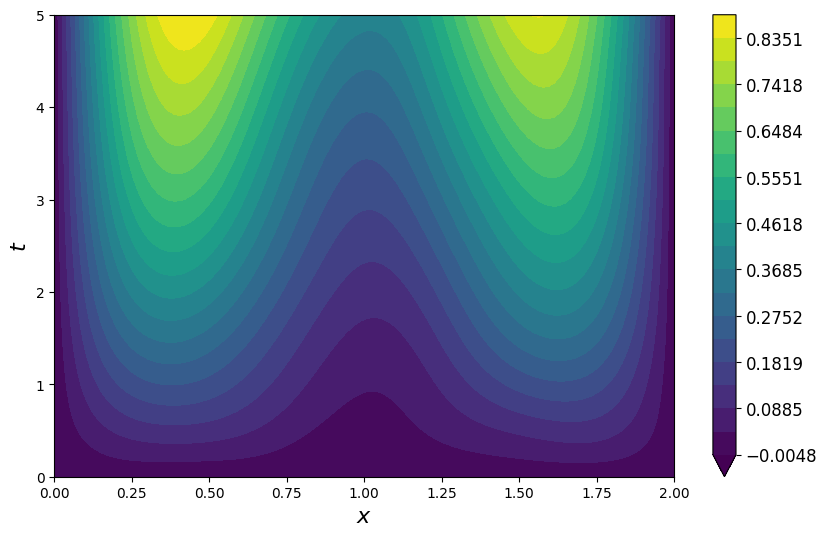

In [ ]:
for j in range(6):
  numerical.plot_solution_PDE(numerical_solutions[j], mesh_x, mesh_t, surface=False)
  numerical.plot_solution_PDE(NN_solution[j].swapaxes(0, 1), mesh_x, mesh_t, surface=False)

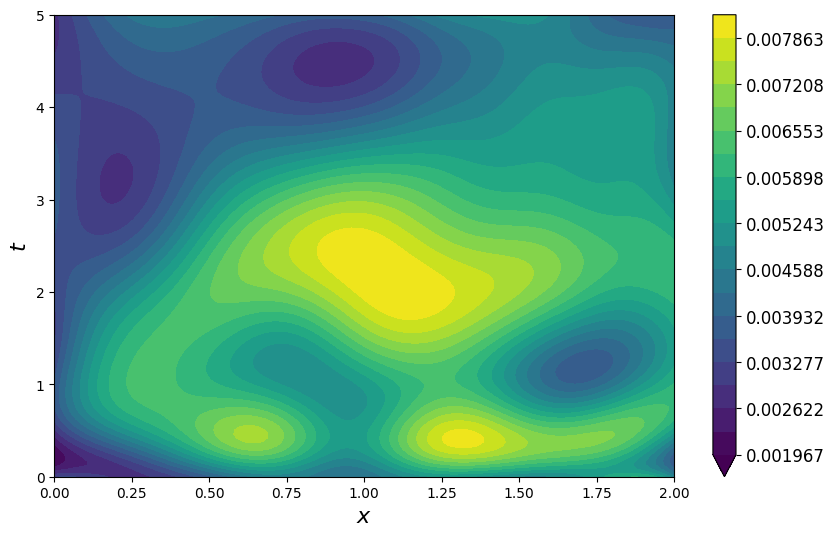

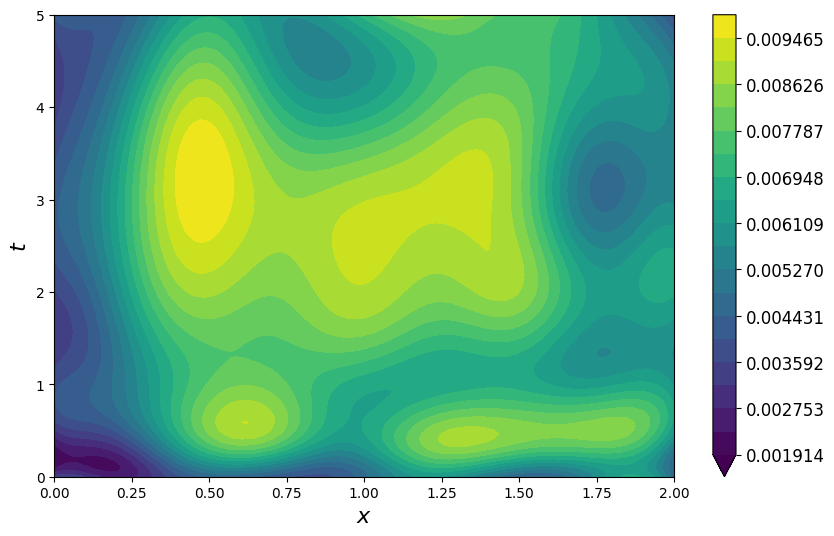

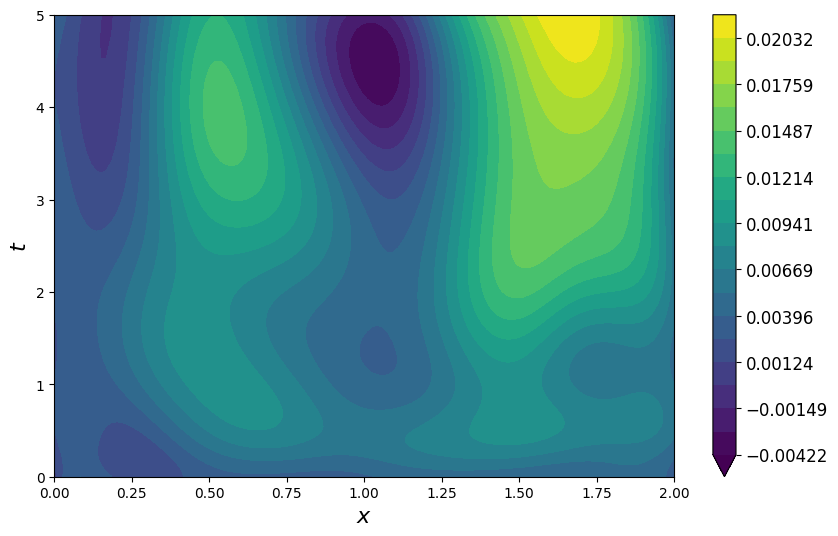

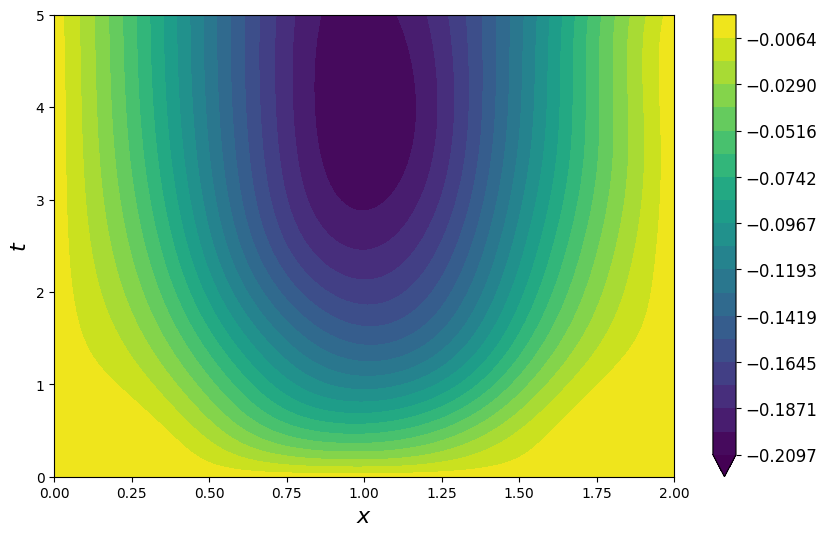

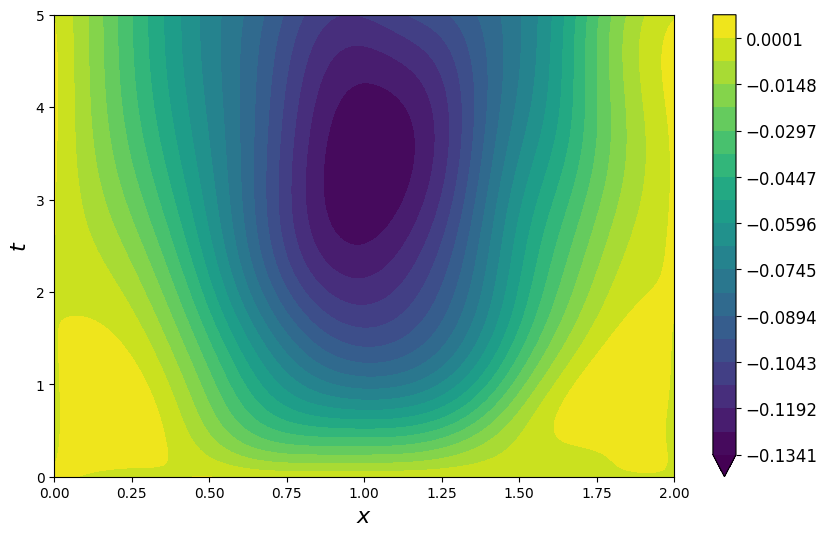

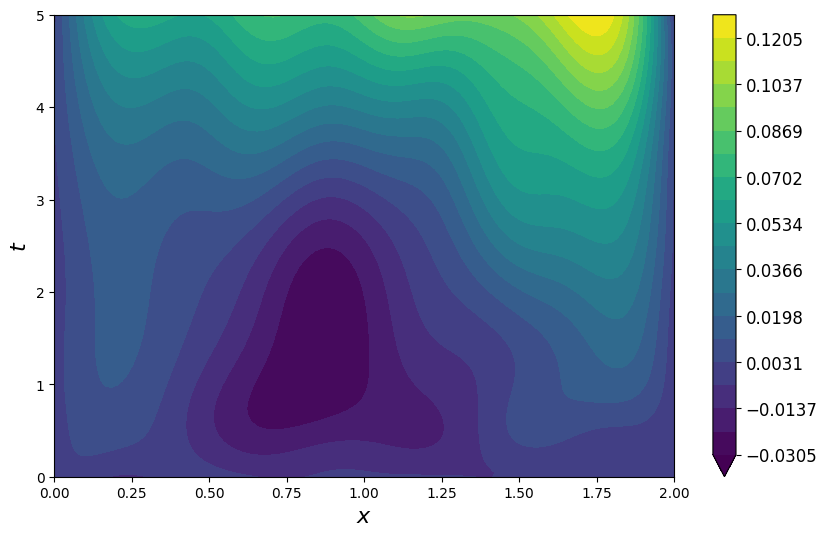

In [ ]:
for i in range(6):
    numerical.plot_solution_PDE(numerical_solutions[i] - NN_solution[i].swapaxes(0, 1), mesh_x, mesh_t, surface=False)

In [ ]:
name = "KPP_Fisher_linear"
PTL_PINN.to('cpu')
torch.save(PTL_PINN.state_dict(), f"/content/PTL-PINNS/ptlpinns/models/train/{name}/model_{name}.pth")

In [ ]:
##log and save the record
log = {
    'name': name,
    'optimizer':optimizer,
    'bias': True,
    'k' :k,
    'equation_info': {
        'D': D_list,
    },
    'domain_info':{
        'L': L,
        'T': T,
    },
    'lr': learning_rate,
    'num_iter': num_iter,
    'step_size': step_size,
    'gamma': gamma,
    'interior_grid': interior_grid,
    'Nx' : Nx,
    'Nt' : Nt,
    'Nbc': Nbc,
    'Nic': Nic,
    'boundary_values': boundary_values,
    'w_pde': pde_weight,
    'w_bc': bc_weight,
    'w_ic': ic_weight,
    'loss_trace': {
        'total': loss_trace,
        'pde': pde_trace,
        'bc': bc_trace,
        'ic': ic_trace,
    },
    'method': 'equally-spaced-noisy'
}

In [ ]:
model_path = f"/content/PTL-PINNS/ptlpinns/models/train/{name}/model_{name}.pth"
save_dir = os.path.dirname(model_path)
json_path = os.path.join(save_dir, f"log_{name}.json")

with open(json_path, 'w') as f:
    json.dump(log, f, indent=4)

print(f"Saved log to {json_path}")